# The STATS NetCDF files

How to use Xarray with the -STATS.nc NetCDF files

In [1]:
import numpy as np
import pandas as pd
import os

import pyopia.classify
import pyopia.process
import pyopia.statistics
import pyopia.pipeline
import pyopia.instrument.silcam
import pyopia.io
import pyopia.tests.testdata

## Loading processed data from disc using Xarray

This is data that would normally be written by {func}`pyopia.io.make_xstats` or at the end of a processing pipeline (see {class}`pyopia.pipeline.Pipeline`)

In [2]:
import xarray

In [3]:
with xarray.open_dataset('test-STATS.nc') as xstats:
    xstats.load()

xstats

<xarray.Dataset>
Dimensions:                     (index: 870)
Coordinates:
  * index                       (index) int32 0 1 2 3 4 ... 865 866 867 868 869
    time                        (index) datetime64[ns] 2018-11-01T14:27:31.83...
Data variables: (12/17)
    export name                 (index) object 'D20181101T142731.838206-PN0' ...
    major_axis_length           (index) float64 6.176 15.52 21.23 ... 6.34 5.779
    minor_axis_length           (index) float64 2.744 13.09 ... 4.598 2.874
    equivalent_diameter         (index) float64 3.909 14.14 ... 5.412 4.068
    minr                        (index) float64 3.0 3.0 ... 2.033e+03 2.037e+03
    minc                        (index) float64 77.0 1.896e+03 ... 1.754e+03
    ...                          ...
    probability_faecal_pellets  (index) float64 0.00343 0.00343 ... 0.00343
    probability_copepod         (index) float64 0.002331 0.002331 ... 0.002331
    probability_diatom_chain    (index) float64 0.005164 0.005164 ... 0.005164
    probability_oily_gas        (index) float64 0.1086 0.1086 ... 0.1086 0.1086
    timestamp                   (index) datetime64[ns] 2018-11-01T14:27:31.83...
    saturation                  (index) float64 21.67 21.67 ... 21.67 21.67
Attributes:
    steps:           [general]\nraw_files = "raw_data/*.silc"\npixel_size = 2...
    Modified:        2023-09-25 19:27:01.897188
    PyOpia version:  0.1.0

## Access the settings used to process the data

This is metada contained within the 'steps' attribute. {func}`pyopia.pipeline.steps_from_xstats` can extract this from the xarray for you:

In [4]:
toml_steps = pyopia.pipeline.steps_from_xstats(xstats)
toml_steps

{'general': {'raw_files': 'raw_data/*.silc', 'pixel_size': 24},
 'steps': {'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'load': {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'},
  'imageprep': {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
   'image_level': 'imraw'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.85},
  'statextract': {'pipeline_class': 'pyopia.process.CalculateStats'},
  'output': {'pipeline_class': 'pyopia.io.StatsH5',
   'output_datafile': './test'}}}

You can use this to modify settings, or re-process a dataset using {class}`pyopia.pipeline.Pipeline`

Or you might want to access some other metadata, such as pixel size, for use in analysis:

In [5]:
toml_steps['general']['pixel_size']

24

We can plot directly from xarray in exactly the same way as from the Pandas DataFrame (so it doesn't matter which you use here). The benefit of 'xstats' as an xarray is that it now contains it's own metadata

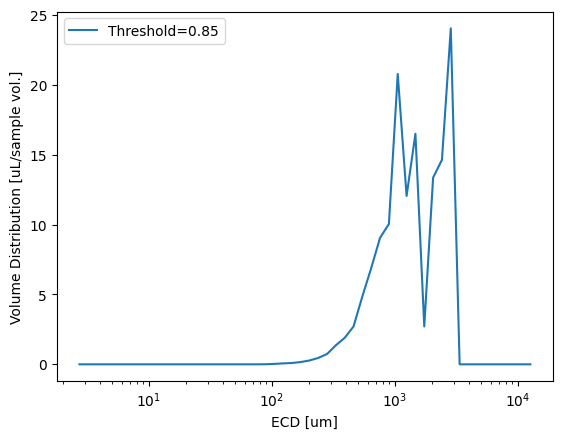

In [6]:
import matplotlib.pyplot as plt

dias, vd = pyopia.statistics.vd_from_stats(xstats, toml_steps['general']['pixel_size'])

plt.plot(dias, vd, label=f"Threshold={toml_steps['steps']['segmentation']['threshold']}")
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')
plt.legend()
plt.show()